In [97]:
import numpy as np
import pandas as pd
import pygplates
import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag
import pmagpy.contribution_builder as cb
from pmagpy import convert_2_magic as convert
import pmagpy.pmagplotlib as pmagplotlib
from IPython.display import Image
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.mpl.geoaxes
import os
import math
import sys
%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_rows', None,'display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load functions

In [98]:
def pmd_spec2df(data_name, down_dip_dip=[120, 26], lab_arrow_top=1):
    '''Load demagnitization data in the ASCII fomat .PMD as a dataframe'''
    # lab_arrow_top = 1 # top marking
    data = []
    with open(data_name, 'r') as f:
            data = f.readlines()
    MeasRecs = []
    volume = float(data[1].strip().replace("=", "= ").split()[-1][0:-2])
    specimen = data[1].strip().replace("=", "= ").split()[0]
    for k in range(3, len(data)):  # read in data
        line = data[k]
        rec = line.split()
        if len(rec) > 1:  # skip blank lines at bottom
            MeasRec = {}
            MeasRec["specimen"] = specimen
            MeasRec["treatment"] = int(rec[0])
            X = np.array([float(rec[1]), float(rec[2]), float(rec[3])])
            Vec = pmag.cart2dir(X)
            MeasRec["x"], MeasRec["y"], MeasRec["z"], MeasRec["int"] = rec[1], rec[2], rec[3], Vec[2]/volume # Am^2
            MeasRec["spec_dec"], MeasRec["spec_inc"] = Vec[0], Vec[1] 
            MeasRec["geo_dec"], MeasRec["geo_inc"] = pmag.dogeo(dec=Vec[0], inc=Vec[1], az=down_dip_dip[0]*lab_arrow_top, pl=down_dip_dip[1]*lab_arrow_top)
            MeasRec["str_dec"], MeasRec["str_inc"] = pmag.dotilt(dec=MeasRec["geo_dec"], inc=MeasRec["geo_inc"], bed_az=down_dip_dip[0], bed_dip=down_dip_dip[1])
            # MeasRec['method_codes'] = meas_type
            MeasRecs.append(MeasRec)
    return pd.DataFrame.from_dict(MeasRecs)

def spec_dopca(data, treatments=[460, 575], geo_str=0, pca_type='DE-BFL-A'):
    '''PCA analysis:
        PCA methods: 
        'DE-BFL-A': best fit line anchored to the origin
        'DE-BFP'  : best fit plane 
    '''
    ind_steps = []
    ind_steps.append(data.index[data['treatment'] == treatments[0]].tolist()[0])
    ind_steps.append(data.index[data['treatment'] == treatments[1]].tolist()[0])

    # we need to add a column for quality
    data['quality']='g'
    # strip off the specimen name and reorder records 
    #  from:  int,dec,inc to: dec,inc,int
    if geo_str == 0:
        tmp1 = data[['treatment', 'spec_dec', 'spec_inc','int', 'quality']].values.tolist()
    if geo_str == 1:
        tmp1 = data[['treatment', 'geo_dec', 'geo_inc','int', 'quality']].values.tolist()
    if geo_str == 2:
        tmp1 = data[['treatment', 'str_dec', 'str_inc','int', 'quality']].values.tolist()
    pca_res = pmag.domean(tmp1, ind_steps[0], ind_steps[1], pca_type)

    return pca_res

def dopca_all(folderpath, spec_A):
    '''Arguments:
        folderpath: directory of all pmd files
        spec_A: df of all dir (planes are not included)
        Returns:
        dir_all 
    '''
    dir_all = []
    for i in os.listdir(folderpath):
        if f'G{i[:-4]}' in spec_A['ID'].tolist():
            spec_sel = spec_A[spec_A['ID'] == f'G{i[:-4]}']
            data = pmd_spec2df(folderpath+i, down_dip_dip=[spec_sel.Dip_ori.tolist()[0], spec_sel.Dip.tolist()[0]], lab_arrow_top=spec_sel.Top_m.tolist()[0])
            if spec_sel.lp.tolist()[0] == 'l': pca_flag = 'DE-BFL-A'
            elif spec_sel.lp.tolist()[0] == 'p': pca_flag = 'DE-BFLP'
            if spec_sel.T_AF.tolist()[0] == 'T':
                pca_res = spec_dopca(data, treatments=[int(spec_sel.STEP1), int(spec_sel.STEP2)], geo_str=1, pca_type=pca_flag)
            elif spec_sel.T_AF.tolist()[0] == 'AF':
                pca_res = spec_dopca(data, treatments=[int(spec_sel.STEP1.tolist()[0]*10), int(spec_sel.STEP1.tolist()[0]*10)], geo_str=1, pca_type=pca_flag)
            pca_res['ID'] = f'G{i[:-4]}'
            # del pca_res["center_of_mass"]
            pca_res.pop('center_of_mass', None)
            # dir_all.append(pd.DataFrame.from_dict(pca_res).iloc[0])
            dir_all.append(pca_res)
    all_pca = pd.merge(spec_A, pd.DataFrame.from_dict(dir_all).sort_values(by='ID'), on='ID')
    return all_pca, dir_all

def create_ellipse(centerlon, centerlat, major_axis, minor_axis, angle, n=100):
    """
    This function enables general error ellipses
    Parameters
    -----------
    centerlon : longitude of the center of the ellipse
    centerlat : latitude of the center of the ellipse
    major_axis : Major axis of ellipse
    minor_axis : Minor axis of ellipse
    angle : angle of major axis in degrees east of north
    n : number of points with which to apporximate the ellipse
    Returns
    ---------
    """
    angle = angle * (np.pi/180)
    glon1 = centerlon
    glat1 = centerlat
    major_axis = major_axis
    minor_axis = minor_axis
    X = []
    Y = []
    for azimuth in np.linspace(-180, 180, n):
        az_rad = azimuth*(np.pi/180)
        radius = ((major_axis*minor_axis)/(((minor_axis*np.cos(az_rad-angle))
                                            ** 2 + (major_axis*np.sin(az_rad-angle))**2)**.5))

        # glon2, glat2, baz = shoot(glon1, glat1, azimuth, radius)
        glon2, glat2, baz = shoot(glon1, glat1, azimuth, radius* (180/np.pi)) # LW
        X.append(glon2) # LW
        Y.append(glat2)
    X.append(X[0])
    Y.append(Y[0])
    return X, Y

def shoot(lon, lat, azimuth, maxdist=None):
    """
    This function enables A95 error ellipses to be drawn around
    paleomagnetic poles in conjunction with equi
    (from: http://www.geophysique.be/2011/02/20/matplotlib-basemap-tutorial-09-drawing-circles/)
    """
    from past.utils import old_div
    glat1 = lat * np.pi / 180.
    glon1 = lon * np.pi / 180.
    scaleLW1 = .96
    s = maxdist / scaleLW1 # LW
    faz = azimuth * np.pi / 180.

    EPS = 0.00000000005

    a = old_div(6378.13, 1.852)
    f = old_div(1, 298.257223563)
    r = 1 - f
    tu = r * np.tan(glat1)
    sf = np.sin(faz)
    cf = np.cos(faz)
    if (cf == 0):
        b = 0.
    else:
        b = 2. * np.arctan2(tu, cf)

    cu = old_div(1., np.sqrt(1 + tu * tu))
    su = tu * cu
    sa = cu * sf
    c2a = 1 - sa * sa
    x = 1. + np.sqrt(1. + c2a * (old_div(1., (r * r)) - 1.))
    x = old_div((x - 2.), x)
    c = 1. - x
    c = old_div((x * x / 4. + 1.), c)
    d = (0.375 * x * x - 1.) * x
    tu = old_div(s, (r * a * c))
    y = tu
    c = y + 1

    sy = np.sin(y)
    cy = np.cos(y)
    cz = np.cos(b + y)
    e = 2. * cz * cz - 1.
    c = y
    x = e * cy
    y = e + e - 1.
    y = (((sy * sy * 4. - 3.) * y * cz * d / 6. + x) *
         d / 4. - cz) * sy * d + tu

    while (np.abs(y - c) > EPS):
        sy = np.sin(y)
        cy = np.cos(y)
        cz = np.cos(b + y)
        e = 2. * cz * cz - 1.
        c = y
        x = e * cy
        y = e + e - 1.
        y = (((sy * sy * 4. - 3.) * y * cz * d / 6. + x) *
             d / 4. - cz) * sy * d + tu

    b = cu * cy * cf - su * sy
    c = r * np.sqrt(sa * sa + b * b)
    d = su * cy + cu * sy * cf
    glat2 = (np.arctan2(d, c) + np.pi) % (2 * np.pi) - np.pi
    c = cu * cy - su * sy * cf
    x = np.arctan2(sy * sf, c)
    c = ((-3. * c2a + 4.) * f + 4.) * c2a * f / 16.
    d = ((e * cy * c + cz) * sy * c + y) * sa
    glon2 = ((glon1 + x - (1. - c) * d * f + np.pi) % (2 * np.pi)) - np.pi

    baz = (np.arctan2(sa, b) + np.pi) % (2 * np.pi)

    glon2 = glon2 * 180/np.pi # LW
    glat2 = glat2 * 180/np.pi # LW
    baz = baz * 180/np.pi # LW

    return (glon2, glat2, baz)

#### Direction rotation with PMGSC

According to Randy Enkin: A computer program package for analysis and presentation of paleomagnetic data (http://palaeo.spb.ru/pmlibrary/pmpapers/enkin_1994.pdf)

There are different ways of rotating sample/specimen directions to in-situ (geographic) and tilt-corrected counterparts for drilled cores and hand samples.

For drilled cores (lab arrows marked down the specimen): alpha = azimuth , beta = 90 - plunge, strike = down dip - 90, bedding dip = dip

For hand samples (lab arrows marked on top of the specimen): alpha = down dip, beta = - dip, strike = down dip - 90, bedding dip = dip

Below are the formulas I used for rotating the South China directions:

Alpha = down dip + 180

Beta = 90 - dip

Strike = dip direction +90

Bedding dip = dip 

#### Direction rotation using pmagpy
pmd_magic for converting PMD files: http://pmagpy.github.io/PmagPy_MagIC.html. According this website, directions measured from the equipment are saved as cartesian values (X, Y, Z) in PMD files, which means that they are the original values without any rotation.

To check rotations, I followed the pmagpy procedure to calculate in-situ and tilt-corrected directions using measurements in cartisian coordinates.

Two functions were used:

1. pmag.dogeo(dec, inc, az, pl), where azimuth and plunge of the X direction (lab arrow) of a specimen

2. pmag.dotilt(dec, inc, bed_az, bed_dip), where bed_az and bed_dip represent bedding dip direction and bedding dip.

### 0. Compare rotated directions using the two software

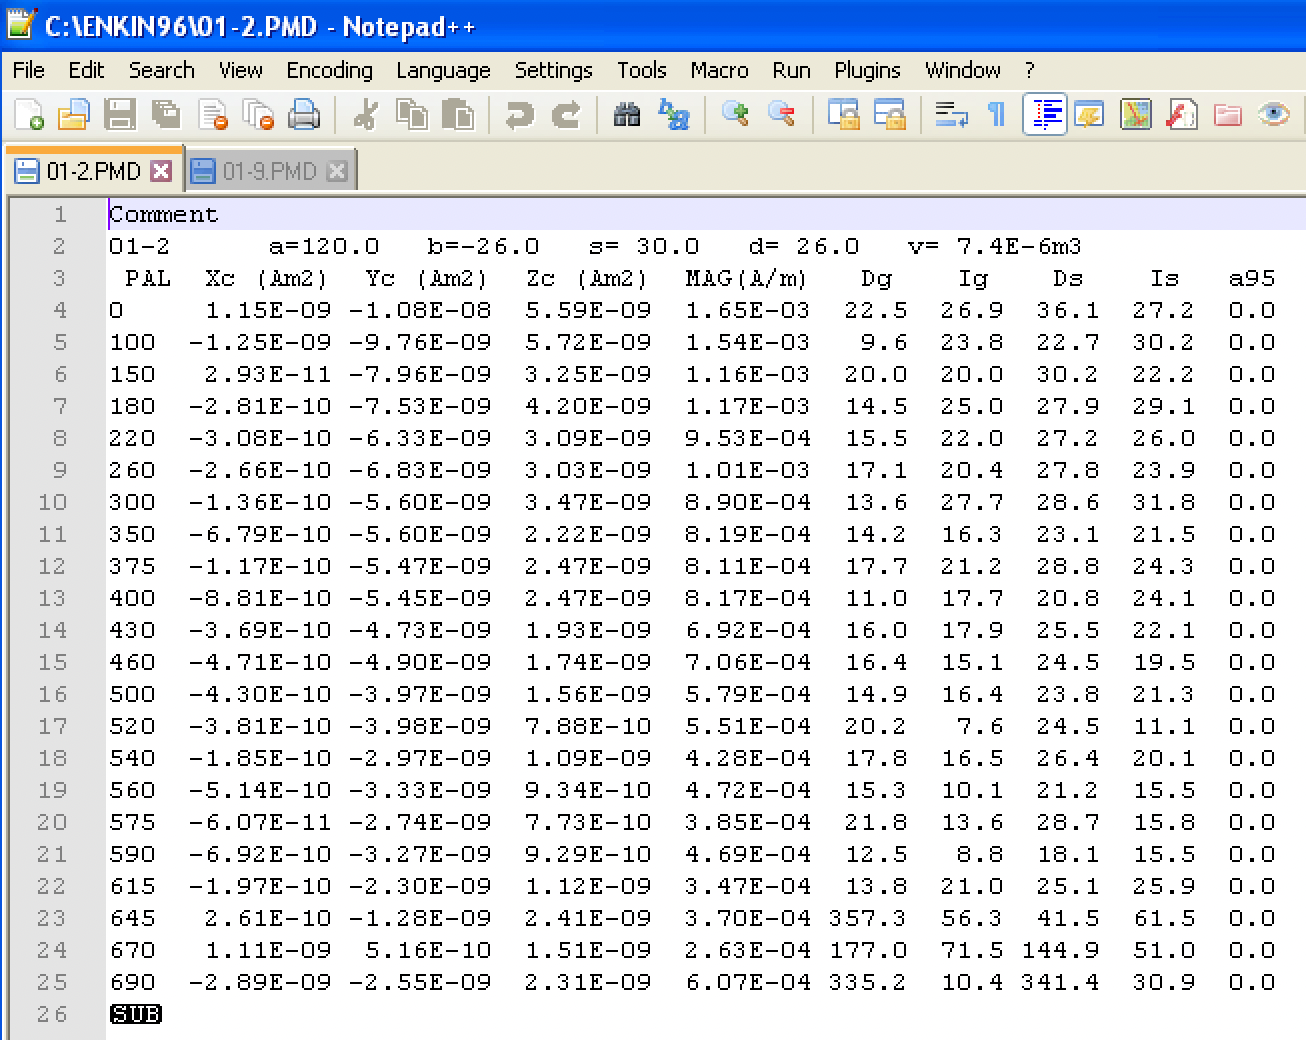

In [192]:
Image(filename='pmgsc_01-2_spec.png', height=450) 

### 1. Correct the same specimen data (01-2.PMD) using pmagpy 

In [101]:
folderpath = '/Users/lei/Desktop/Projects/Manuscripts/Accomplished/SCB_Devonian/Project_details/Measurements_GY/GuanYang/20220108_check/Wu_et.al_SCB_Devonian_Samples_good/'
filename = '01-2' + '.PMD'
spec_name = folderpath + filename
specimen = pmd_spec2df(spec_name)
# specimen.columns
specimen

,specimen,treatment,x,y,z,int,spec_dec,spec_inc,geo_dec,geo_inc,str_dec,str_inc
0,G1-2,0,1.15E-09,-1.08E-08,5.59E-09,0.001651,276.078037,27.234110,22.525895,26.909544,36.078037,27.234110
1,G1-2,100,-1.25E-09,-9.76E-09,5.72E-09,0.001538,262.701645,30.170179,9.593481,23.801034,22.701645,30.170179
2,G1-2,150,2.93E-11,-7.96E-09,3.25E-09,0.001162,270.210899,22.209638,20.036243,19.952129,30.210899,22.209638
3,G1-2,180,-2.81E-10,-7.53E-09,4.20E-09,0.001166,267.862862,29.134463,14.461386,25.043640,27.862862,29.134463
4,G1-2,220,-3.08E-10,-6.33E-09,3.09E-09,0.000953,267.214345,25.992698,15.547978,22.009028,27.214345,25.992698
5,G1-2,260,-2.66E-10,-6.83E-09,3.03E-09,0.001010,267.769696,23.907469,17.075572,20.404758,27.769696,23.907469
6,G1-2,300,-1.36E-10,-5.60E-09,3.47E-09,0.000890,268.608805,31.776567,13.645072,27.662636,28.608805,31.776567
7,G1-2,350,-6.79E-10,-5.60E-09,2.22E-09,0.000819,263.086634,21.481932,14.211133,16.262882,23.086634,21.481932
8,G1-2,375,-1.17E-10,-5.47E-09,2.47E-09,0.000811,268.774665,24.296828,17.747177,21.178659,28.774665,24.296828
9,G1-2,400,-8.81E-10,-5.45E-09,2.47E-09,0.000817,260.817492,24.103891,11.018529,17.650215,20.817492,24.103891


#### Do PCA to find a best-fit line/plane

In [102]:
spec_dopca(specimen, treatments=[460, 575], geo_str=1, pca_type='DE-BFL-A')

{'calculation_type': 'DE-BFL-A',
 'center_of_mass': [0.0004816198798159294,
  0.00015184593425962982,
  0.00011921564500834468],
 'specimen_direction_type': 'l',
 'specimen_dec': 17.49910938906061,
 'specimen_inc': 13.282920854337295,
 'specimen_n': 6,
 'measurement_step_min': 460,
 'measurement_step_max': 575,
 'specimen_mad': 3.99980412997003}

#### Compare the pca results with those from PMGSC (with parameters I believer are correct according to the above screenshot) 

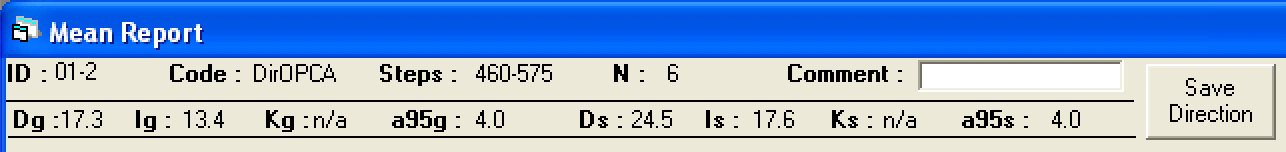

In [193]:
Image(filename='pmgsc_01-2_pca.png', height=70) 

### 2. Repeat the procedures for all PMD files

#### Load all information about individual specimens (data_info), including demagnetization methods (AF or T), PCA approach (best-fit line or plane) and fitting demag intervals, bedding attitude (down-dip direction, dip), the location of lab arrows (top of a bedding plane), and how directions are grouped by components

In [104]:
data_info = pd.read_excel('/Users/lei/Desktop/Projects/Manuscripts/Accomplished/SCB_Devonian/Project_details/Measurements_GY/GuanYang/20220108_check/data_info.xlsx',sheet_name='info')
spec_A = data_info.dropna(subset=['A_Group'])
spec_A = spec_A[spec_A.lp=='l']
spec_B = data_info.dropna(subset=['B_Group'])
spec_B = spec_B[spec_B.lp=='l']
spec_A.tail()

,ID,T_AF,CODE,STEP1,STEP2,Dip_ori,Dip,Top_m,A_Group,B_Group,lp
67,G37-10,T,DirOPCA,540.0,645.0,115.0,24.0,1.0,A37,NaN,l
68,G38-6,T,DirOPCA,500.0,560.0,112.0,25.0,1.0,A38,NaN,l
69,G38-8,T,DirOPCA,430.0,540.0,112.0,25.0,1.0,A38,NaN,l
70,G38-9,T,DirOPCA,500.0,575.0,112.0,25.0,1.0,A38,NaN,l
71,G42-5,T,DirOPCA,400.0,500.0,105.0,46.0,-1.0,A42-45,NaN,l


#### Do PCA to all the specimens, using relevant information (e.g., pca method and interval) from data_info.
#### The results are saved in two dataframes: all_pca_A and all_pca_B

In [105]:
all_pca_A, dir_all_A = dopca_all(folderpath, spec_A) 
all_pca_B, dir_all_B = dopca_all(folderpath, spec_B)

all_pca_A["slon"], all_pca_A["slat"] = 111.1, 25.5
all_pca_B["slon"], all_pca_B["slat"] = 111.1, 25.5

all_pca_A["dec_tc"], all_pca_A["inc_tc"] = np.nan, np.nan
all_pca_B["dec_tc"], all_pca_B["inc_tc"] = np.nan, np.nan

all_pca_A["vgp_lon_is"], all_pca_A["vgp_lat_is"], all_pca_A["vgp_lon_tc"], all_pca_A["vgp_lat_tc"] = np.nan, np.nan, np.nan, np.nan
all_pca_B["vgp_lon_is"], all_pca_B["vgp_lat_is"], all_pca_B["vgp_lon_tc"], all_pca_B["vgp_lat_tc"] = np.nan, np.nan, np.nan, np.nan

for i, row in all_pca_A.iterrows():
    all_pca_A["dec_tc"][i], all_pca_A["inc_tc"][i] = pmag.dotilt(dec=row["specimen_dec"], inc=row["specimen_inc"], bed_az=row['Dip_ori'], bed_dip=row['Dip'])
    all_pca_A["vgp_lon_is"][i], all_pca_A["vgp_lat_is"][i], tmp1, tmp2 = pmag.dia_vgp(row["specimen_dec"], row["specimen_inc"], row["specimen_mad"], row["slat"], row["slon"])
    all_pca_A["vgp_lon_tc"][i], all_pca_A["vgp_lat_tc"][i], tmp1, tmp2 = pmag.dia_vgp(all_pca_A["dec_tc"][i], all_pca_A["inc_tc"][i], row["specimen_mad"], row["slat"], row["slon"])

for i, row in all_pca_B.iterrows():
    all_pca_B["dec_tc"][i], all_pca_B["inc_tc"][i] = pmag.dotilt(dec=row["specimen_dec"], inc=row["specimen_inc"], bed_az=row['Dip_ori'], bed_dip=row['Dip'])
    all_pca_B["vgp_lon_is"][i], all_pca_B["vgp_lat_is"][i], tmp1, tmp2 = pmag.dia_vgp(row["specimen_dec"], row["specimen_inc"], row["specimen_mad"], row["slat"], row["slon"])
    all_pca_B["vgp_lon_tc"][i], all_pca_B["vgp_lat_tc"][i], tmp1, tmp2 = pmag.dia_vgp(all_pca_B["dec_tc"][i], all_pca_B["inc_tc"][i], row["specimen_mad"], row["slat"], row["slon"])

In [106]:
all_pca_A.tail(2)

,ID,T_AF,CODE,STEP1,STEP2,Dip_ori,Dip,Top_m,A_Group,B_Group,lp,calculation_type,specimen_direction_type,specimen_dec,specimen_inc,specimen_n,measurement_step_min,measurement_step_max,specimen_mad,slon,slat,dec_tc,inc_tc,vgp_lon_is,vgp_lat_is,vgp_lon_tc,vgp_lat_tc
68,G38-9,T,DirOPCA,500.0,575.0,112.0,25.0,1.0,A38,NaN,l,DE-BFL-A,l,17.699002,25.990849,5,500,575,16.614086,111.1,25.5,29.883139,25.192340,233.119261,69.612716,219.006097,59.357039
69,G42-5,T,DirOPCA,400.0,500.0,105.0,46.0,-1.0,A42-45,NaN,l,DE-BFL-A,l,345.704932,-31.502082,4,400,500,3.276521,111.1,25.5,333.163808,-3.604873,310.691213,45.245301,338.675486,52.318781


In [107]:
all_pca_A.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70 entries, 0 to 69
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       70 non-null     object 
 1   T_AF                     70 non-null     object 
 2   CODE                     70 non-null     object 
 3   STEP1                    70 non-null     float64
 4   STEP2                    70 non-null     float64
 5   Dip_ori                  70 non-null     float64
 6   Dip                      70 non-null     float64
 7   Top_m                    70 non-null     float64
 8   A_Group                  70 non-null     object 
 9   B_Group                  0 non-null      object 
 10  lp                       70 non-null     object 
 11  calculation_type         70 non-null     object 
 12  specimen_direction_type  70 non-null     object 
 13  specimen_dec             70 non-null     float64
 14  specimen_inc             70 

#### Filter out directions with high error (maximum angular deviation MAD>15deg).

In [108]:
all_pca_A = all_pca_A[(all_pca_A['specimen_mad'] <= 15)] #  & (all_pca_A['A_Group'] != 'A0')
all_pca_A.columns

Index(['ID', 'T_AF', 'CODE', 'STEP1', 'STEP2', 'Dip_ori', 'Dip', 'Top_m',
       'A_Group', 'B_Group', 'lp', 'calculation_type',
       'specimen_direction_type', 'specimen_dec', 'specimen_inc', 'specimen_n',
       'measurement_step_min', 'measurement_step_max', 'specimen_mad', 'slon',
       'slat', 'dec_tc', 'inc_tc', 'vgp_lon_is', 'vgp_lat_is', 'vgp_lon_tc',
       'vgp_lat_tc'],
      dtype='object')

#### Filter directions

In [109]:
# all_pca_A = all_pca_A[(all_pca_A['A_Group'] != 'A0') & (all_pca_A['A_Group'] != 'A04-05') & (all_pca_A['A_Group'] != 'A08-09') & (all_pca_A['A_Group'] != 'A04-05')]
# all_pca_A = all_pca_A.drop(all_pca_A[(all_pca_A['specimen_dec'] > 50) & (all_pca_A['specimen_dec'] < 90)].index.tolist()) # remove two easter low inclination directions

#### Calculate A mean directions and vgps

In [110]:
Adir_is = ipmag.fisher_mean(all_pca_A.specimen_dec.tolist(), all_pca_A.specimen_inc.tolist())
Adir_tc = ipmag.fisher_mean(all_pca_A.dec_tc.tolist(), all_pca_A.inc_tc.tolist())
Avgp_is = ipmag.fisher_mean(all_pca_A.vgp_lon_is.tolist(), all_pca_A.vgp_lat_is.tolist())
Avgp_tc = ipmag.fisher_mean(all_pca_A.vgp_lon_tc.tolist(), all_pca_A.vgp_lat_tc.tolist())

print('A dir_is: ', ipmag.fisher_mean(all_pca_A.specimen_dec.tolist(), all_pca_A.specimen_inc.tolist()))
print('A dir_tc: ', ipmag.fisher_mean(all_pca_A.dec_tc.tolist(), all_pca_A.inc_tc.tolist()))
print('A vgp_is: ', ipmag.fisher_mean(all_pca_A.vgp_lon_is.tolist(), all_pca_A.vgp_lat_is.tolist()))
print('A vgp_tc: ', ipmag.fisher_mean(all_pca_A.vgp_lon_tc.tolist(), all_pca_A.vgp_lat_tc.tolist()))

A dir_is:  {'dec': 4.9765245326192, 'inc': 16.148711003318237, 'n': 66, 'r': 60.354217434252966, 'k': 11.513018654730885, 'alpha95': 5.384231252873035, 'csd': 23.87208843748644}
A dir_tc:  {'dec': 13.784267219721801, 'inc': 22.156816817924085, 'n': 66, 'r': 61.00559650376004, 'k': 13.01456721487066, 'alpha95': 5.036773880915497, 'csd': 22.452781680958267}
A vgp_is:  {'dec': 275.2561754844582, 'inc': 72.48149634907551, 'n': 66, 'r': 62.03567544155855, 'k': 16.396235737457985, 'alpha95': 4.449678368208706, 'csd': 20.003820184360297}
A vgp_tc:  {'dec': 244.78451923105757, 'inc': 71.44754392175402, 'n': 66, 'r': 62.4496146256465, 'k': 18.307871722752346, 'alpha95': 4.196870732323662, 'csd': 18.930674514023462}


#### Plot all directions and vgps associated with A

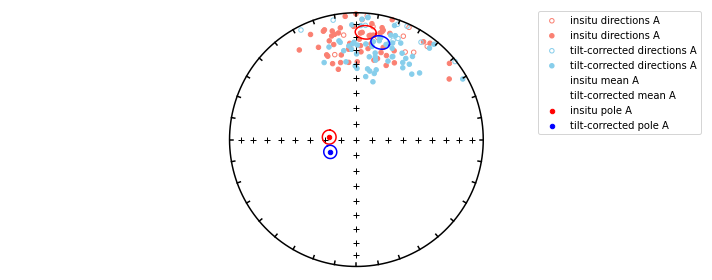

In [111]:
plt.figure(num=1,figsize=(10,4))
ipmag.plot_net(fignum=1)
ipmag.plot_di(all_pca_A.specimen_dec.tolist(), all_pca_A.specimen_inc.tolist(), color='salmon', label='insitu directions A')
ipmag.plot_di(all_pca_A.dec_tc.tolist(), all_pca_A.inc_tc.tolist(), color='skyblue', label='tilt-corrected directions A')
ipmag.plot_di_mean(Adir_is['dec'], Adir_is['inc'], Adir_is['alpha95'], markersize=0, color='r', label='insitu mean A')
ipmag.plot_di_mean(Adir_tc['dec'], Adir_tc['inc'], Adir_tc['alpha95'], markersize=0, color='b', label='tilt-corrected mean A')
ipmag.plot_di_mean(Avgp_is['dec'], Avgp_is['inc'], Avgp_is['alpha95'], color='r', label='insitu pole A')
ipmag.plot_di_mean(Avgp_tc['dec'], Avgp_tc['inc'], Avgp_tc['alpha95'], color='b', label='tilt-corrected pole A')
plt.legend();

#### Perform the fold test to constrain the acqusition age of A relative to the main phase of folding during the Indosinian orogeny

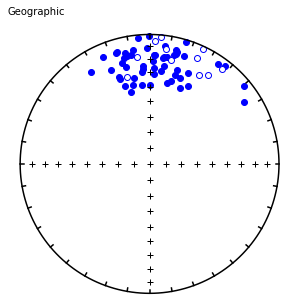

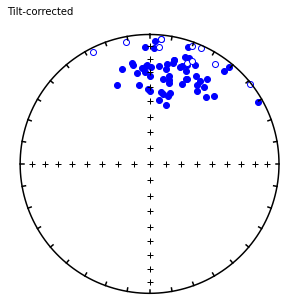

doing  200  iterations...please be patient.....

tightest grouping of vectors obtained at (95% confidence bounds):
139 - 139 percent unfolding
range of all bootstrap samples: 
139  -  139 percent unfolding


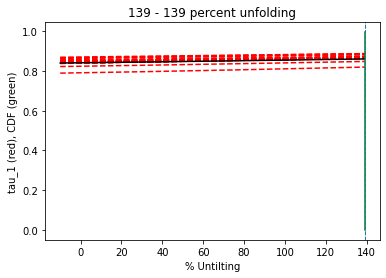

In [112]:
diddd_array = ipmag.make_diddd_array(all_pca_A.specimen_dec.tolist(), all_pca_A.specimen_inc.tolist(), all_pca_A.Dip_ori.tolist(), all_pca_A.Dip.tolist())
ipmag.bootstrap_fold_test(diddd_array, num_sims=200, min_untilt=-10, max_untilt=140)

#### Expanded list of A directions

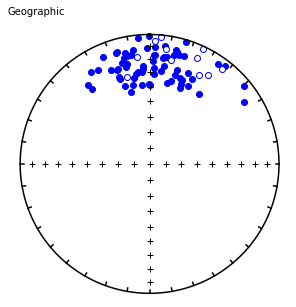

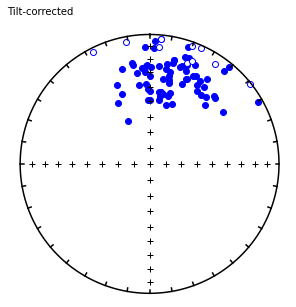

doing  500  iterations...please be patient.....

tightest grouping of vectors obtained at (95% confidence bounds):
8 - 139 percent unfolding
range of all bootstrap samples: 
-10  -  139 percent unfolding


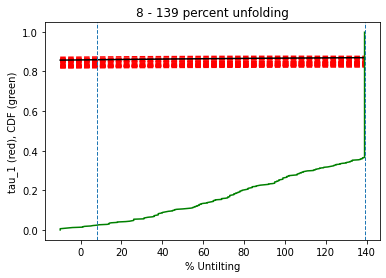

<Figure size 432x288 with 0 Axes>

In [181]:
exA = pd.concat([all_pca_B[(all_pca_B['specimen_dec']>320) & (all_pca_B['specimen_inc']<40)], all_pca_B[(all_pca_B['specimen_dec']<50) & (all_pca_B['specimen_inc']<40)]])
all_pca_A_exp = all_pca_A.append(exA)
all_pca_B_exp = all_pca_B.drop(exA_ind)
# print(len(all_pca_A), len(all_pca_A_exp))
diddd_array = ipmag.make_diddd_array(all_pca_A_exp.specimen_dec.tolist(), all_pca_A_exp.specimen_inc.tolist(), all_pca_A_exp.Dip_ori.tolist(), all_pca_A_exp.Dip.tolist())
ipmag.bootstrap_fold_test(diddd_array, num_sims=500, min_untilt=-10, max_untilt=140);
# plt.savefig('/Users/lei/Desktop/Projects/Manuscripts/Accomplished/SCB_Devonian/WordVersions/GR_1221/res_ftA.pdf')

A dir_is:  {'dec': 3.4440259736870495, 'inc': 18.363931475102486, 'n': 81, 'r': 73.98988000823931, 'k': 11.412072845261937, 'alpha95': 4.8733772159239885, 'csd': 23.977436598274505}
A dir_tc:  {'dec': 13.859991015487681, 'inc': 26.048331055357444, 'n': 81, 'r': 74.26287462922814, 'k': 11.874500710209361, 'alpha95': 4.768692690538671, 'csd': 23.50592466742007}
A vgp_is:  {'dec': 279.26017904110165, 'inc': 73.95484808516893, 'n': 81, 'r': 75.74931038312673, 'k': 15.236093891917971, 'alpha95': 4.168090514250931, 'csd': 20.751438075560436}
A vgp_tc:  {'dec': 239.4071124198242, 'inc': 73.30331107616075, 'n': 81, 'r': 75.85612234947021, 'k': 15.552469447200107, 'alpha95': 4.1225527797668, 'csd': 20.53928591295409}


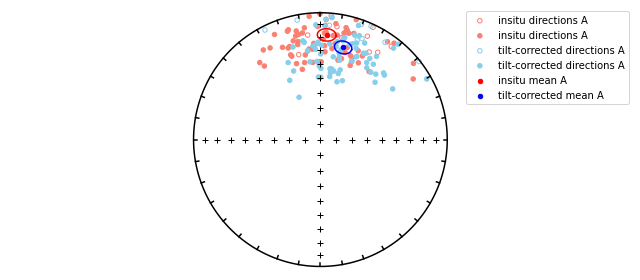

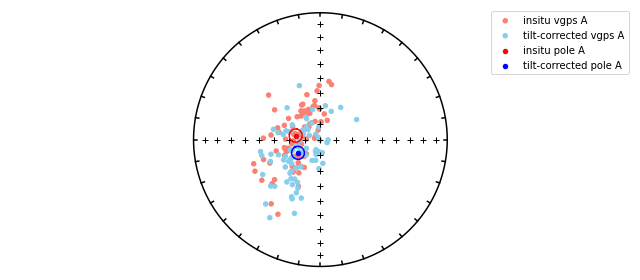

In [190]:
Adir_is_exp = ipmag.fisher_mean(all_pca_A_exp.specimen_dec.tolist(), all_pca_A_exp.specimen_inc.tolist())
Adir_tc_exp = ipmag.fisher_mean(all_pca_A_exp.dec_tc.tolist(), all_pca_A_exp.inc_tc.tolist())
Avgp_is_exp = ipmag.fisher_mean(all_pca_A_exp.vgp_lon_is.tolist(), all_pca_A_exp.vgp_lat_is.tolist())
Avgp_tc_exp = ipmag.fisher_mean(all_pca_A_exp.vgp_lon_tc.tolist(), all_pca_A_exp.vgp_lat_tc.tolist())

print('A dir_is: ', ipmag.fisher_mean(all_pca_A_exp.specimen_dec.tolist(), all_pca_A_exp.specimen_inc.tolist()))
print('A dir_tc: ', ipmag.fisher_mean(all_pca_A_exp.dec_tc.tolist(), all_pca_A_exp.inc_tc.tolist()))
print('A vgp_is: ', ipmag.fisher_mean(all_pca_A_exp.vgp_lon_is.tolist(), all_pca_A_exp.vgp_lat_is.tolist()))
print('A vgp_tc: ', ipmag.fisher_mean(all_pca_A_exp.vgp_lon_tc.tolist(), all_pca_A_exp.vgp_lat_tc.tolist()))

plt.figure(num=1,figsize=(9,4))
ipmag.plot_net(fignum=1)
ipmag.plot_di(all_pca_A_exp.specimen_dec.tolist(), all_pca_A_exp.specimen_inc.tolist(), color='salmon', label='insitu directions A')
ipmag.plot_di(all_pca_A_exp.dec_tc.tolist(), all_pca_A_exp.inc_tc.tolist(), color='skyblue', label='tilt-corrected directions A')
ipmag.plot_di_mean(Adir_is_exp['dec'], Adir_is_exp['inc'], Adir_is_exp['alpha95'], color='r', label='insitu mean A')
ipmag.plot_di_mean(Adir_tc_exp['dec'], Adir_tc_exp['inc'], Adir_tc_exp['alpha95'], color='b', label='tilt-corrected mean A')
plt.legend();
# plt.savefig('/Users/lei/Desktop/Projects/Manuscripts/Accomplished/SCB_Devonian/WordVersions/GR_1221/res_A_dir.pdf')
plt.figure(num=2,figsize=(9,4))
ipmag.plot_net(fignum=2)
ipmag.plot_di(all_pca_A_exp.vgp_lon_is.tolist(), all_pca_A_exp.vgp_lat_is.tolist(), color='salmon', label='insitu vgps A')
ipmag.plot_di(all_pca_A_exp.vgp_lon_tc.tolist(), all_pca_A_exp.vgp_lat_tc.tolist(), color='skyblue', label='tilt-corrected vgps A')
ipmag.plot_di_mean(Avgp_is_exp['dec'], Avgp_is_exp['inc'], Avgp_is_exp['alpha95'], color='r', label='insitu pole A')
ipmag.plot_di_mean(Avgp_tc_exp['dec'], Avgp_tc_exp['inc'], Avgp_tc_exp['alpha95'], color='b', label='tilt-corrected pole A')
plt.legend();
# plt.savefig('/Users/lei/Desktop/Projects/Manuscripts/Accomplished/SCB_Devonian/WordVersions/GR_1221/res_A_vgp.pdf')

### Repeat the same procedures to B directions and vgps

#### Apply filters

In [115]:
all_pca_B = all_pca_B[(all_pca_B['specimen_mad'] <= 15) & (all_pca_B['ID'] != 'G45-4')] #  & (all_pca_B['B_Group'] != 'B0')
# all_pca_B[(all_pca_B['specimen_inc'] > 10) & (all_pca_B['specimen_inc'] < 20)]

#### Calculate B mean directions and vgps

In [116]:
Bdir_is = ipmag.fisher_mean(all_pca_B.specimen_dec.tolist(), all_pca_B.specimen_inc.tolist())
Bdir_tc = ipmag.fisher_mean(all_pca_B.dec_tc.tolist(), all_pca_B.inc_tc.tolist())
Bvgp_is = ipmag.fisher_mean(all_pca_B.vgp_lon_is.tolist(), all_pca_B.vgp_lat_is.tolist())
Bvgp_tc = ipmag.fisher_mean(all_pca_B.vgp_lon_tc.tolist(), all_pca_B.vgp_lat_tc.tolist())

print('B dir_is: ', ipmag.fisher_mean(all_pca_B.specimen_dec.tolist(), all_pca_B.specimen_inc.tolist()))
print('B dir_tc: ', ipmag.fisher_mean(all_pca_B.dec_tc.tolist(), all_pca_B.inc_tc.tolist()))
print('B vgp_is: ', ipmag.fisher_mean(all_pca_B.vgp_lon_is.tolist(), all_pca_B.vgp_lat_is.tolist()))
print('B vgp_tc: ', ipmag.fisher_mean(all_pca_B.vgp_lon_tc.tolist(), all_pca_B.vgp_lat_tc.tolist()))

B dir_is:  {'dec': 354.82298205432, 'inc': 47.53050107627977, 'n': 52, 'r': 37.1416935433886, 'k': 3.4324234830482223, 'alpha95': 12.631254548403136, 'csd': 43.72044630080661}
B dir_tc:  {'dec': 29.143632856268905, 'inc': 56.45656915843639, 'n': 52, 'r': 37.84779249454806, 'k': 3.60367808204854, 'alpha95': 12.210313476059481, 'csd': 42.66895676527222}
B vgp_is:  {'dec': 64.77312566612544, 'inc': 83.37632643443091, 'n': 52, 'r': 35.67757652438101, 'k': 3.1245360148987276, 'alpha95': 13.51183515299169, 'csd': 45.823921405860865}
B vgp_tc:  {'dec': 160.69112173449275, 'inc': 63.141831254541565, 'n': 52, 'r': 35.2414860663735, 'k': 3.0432292625700446, 'alpha95': 13.77685982250314, 'csd': 46.43203126952541}


#### Plot all directions and vgps associated with B

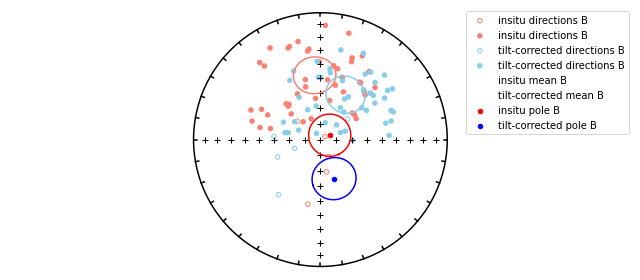

In [160]:
plt.figure(num=2,figsize=(9,4))
ipmag.plot_net(fignum=2)
ipmag.plot_di(all_pca_B.specimen_dec.tolist(), all_pca_B.specimen_inc.tolist(),color='salmon', label='insitu directions B')
ipmag.plot_di(all_pca_B.dec_tc.tolist(), all_pca_B.inc_tc.tolist(),color='skyblue', label='tilt-corrected directions B')
ipmag.plot_di_mean(Bdir_is['dec'], Bdir_is['inc'], Bdir_is['alpha95'], markersize=0, color='salmon', label='insitu mean B')
ipmag.plot_di_mean(Bdir_tc['dec'], Bdir_tc['inc'], Bdir_tc['alpha95'], markersize=0, color='skyblue', label='tilt-corrected mean B')
ipmag.plot_di_mean(Bvgp_is['dec'], Bvgp_is['inc'], Bvgp_is['alpha95'], color='r', label='insitu pole B')
ipmag.plot_di_mean(Bvgp_tc['dec'], Bvgp_tc['inc'], Bvgp_tc['alpha95'], color='b', label='tilt-corrected pole B')
plt.legend();

#### Perform the fold test to B

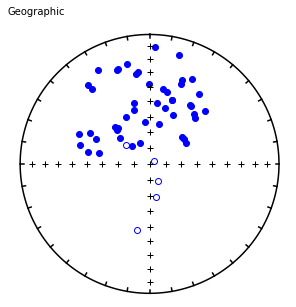

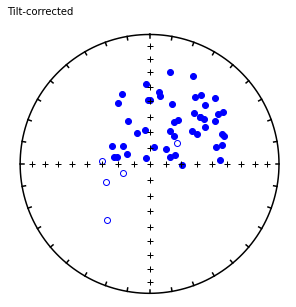

doing  200  iterations...please be patient.....

tightest grouping of vectors obtained at (95% confidence bounds):
67 - 139 percent unfolding
range of all bootstrap samples: 
65  -  139 percent unfolding


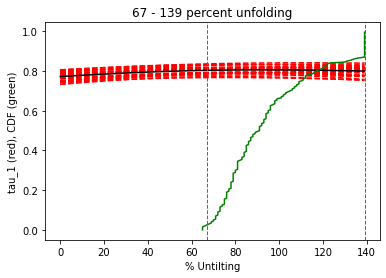

In [118]:
diddd_array = ipmag.make_diddd_array(all_pca_B.specimen_dec.tolist(), all_pca_B.specimen_inc.tolist(), all_pca_B.Dip_ori.tolist(), all_pca_B.Dip.tolist())
ipmag.bootstrap_fold_test(diddd_array, num_sims=200, min_untilt=0, max_untilt=140)

A dir_is:  {'dec': 353.4428437839125, 'inc': 58.645552513979695, 'n': 37, 'r': 24.442286557582914, 'k': 2.8667639347781444, 'alpha95': 17.173019949133245, 'csd': 47.83976666833267}
A dir_tc:  {'dec': 42.50649939364086, 'inc': 62.66198917248079, 'n': 37, 'r': 24.700450834852862, 'k': 2.92693655000072, 'alpha95': 16.90456345003952, 'csd': 47.345462669067516}
A vgp_is:  {'dec': 89.05490886033927, 'inc': 75.1195723383017, 'n': 37, 'r': 22.555886554426355, 'k': 2.492364805610973, 'alpha95': 19.190347672600485, 'csd': 51.30730625803499}
A vgp_tc:  {'dec': 153.9964943643721, 'inc': 52.51091470883036, 'n': 37, 'r': 22.667825000806694, 'k': 2.5118308981034825, 'alpha95': 19.067445217397445, 'csd': 51.1081098613809}


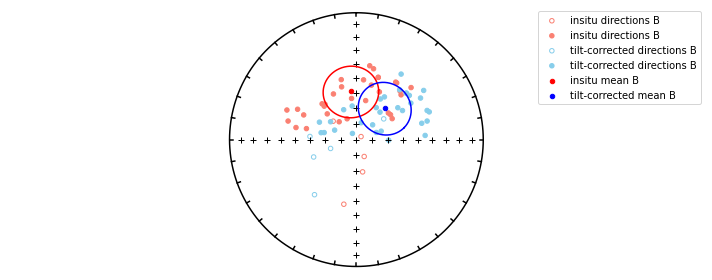

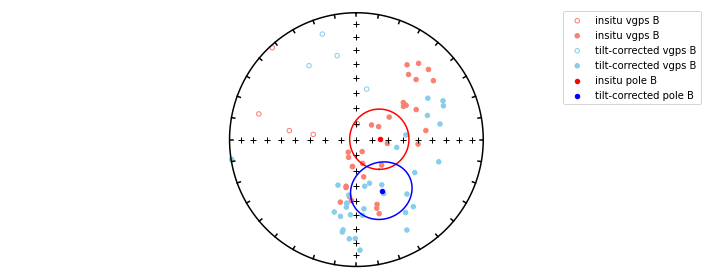

In [180]:
Bdir_is_exp = ipmag.fisher_mean(all_pca_B_exp.specimen_dec.tolist(), all_pca_B_exp.specimen_inc.tolist())
Bdir_tc_exp = ipmag.fisher_mean(all_pca_B_exp.dec_tc.tolist(), all_pca_B_exp.inc_tc.tolist())
Bvgp_is_exp = ipmag.fisher_mean(all_pca_B_exp.vgp_lon_is.tolist(), all_pca_B_exp.vgp_lat_is.tolist())
Bvgp_tc_exp = ipmag.fisher_mean(all_pca_B_exp.vgp_lon_tc.tolist(), all_pca_B_exp.vgp_lat_tc.tolist())

print('A dir_is: ', ipmag.fisher_mean(all_pca_B_exp.specimen_dec.tolist(), all_pca_B_exp.specimen_inc.tolist()))
print('A dir_tc: ', ipmag.fisher_mean(all_pca_B_exp.dec_tc.tolist(), all_pca_B_exp.inc_tc.tolist()))
print('A vgp_is: ', ipmag.fisher_mean(all_pca_B_exp.vgp_lon_is.tolist(), all_pca_B_exp.vgp_lat_is.tolist()))
print('A vgp_tc: ', ipmag.fisher_mean(all_pca_B_exp.vgp_lon_tc.tolist(), all_pca_B_exp.vgp_lat_tc.tolist()))

plt.figure(num=1,figsize=(10,4))
ipmag.plot_net(fignum=1)
ipmag.plot_di(all_pca_B_exp.specimen_dec.tolist(), all_pca_B_exp.specimen_inc.tolist(), color='salmon', label='insitu directions B')
ipmag.plot_di(all_pca_B_exp.dec_tc.tolist(), all_pca_B_exp.inc_tc.tolist(), color='skyblue', label='tilt-corrected directions B')
ipmag.plot_di_mean(Bdir_is_exp['dec'], Bdir_is_exp['inc'], Bdir_is_exp['alpha95'], color='r', label='insitu mean B')
ipmag.plot_di_mean(Bdir_tc_exp['dec'], Bdir_tc_exp['inc'], Bdir_tc_exp['alpha95'], color='b', label='tilt-corrected mean B')
plt.legend();
# plt.savefig('/Users/lei/Desktop/Projects/Manuscripts/Accomplished/SCB_Devonian/WordVersions/GR_1221/res_B_dir.pdf')
plt.figure(num=2,figsize=(10,4))
ipmag.plot_net(fignum=2)
ipmag.plot_di(all_pca_B_exp.vgp_lon_is.tolist(), all_pca_B_exp.vgp_lat_is.tolist(), color='salmon', label='insitu vgps B')
ipmag.plot_di(all_pca_B_exp.vgp_lon_tc.tolist(), all_pca_B_exp.vgp_lat_tc.tolist(), color='skyblue', label='tilt-corrected vgps B')
ipmag.plot_di_mean(Bvgp_is_exp['dec'], Bvgp_is_exp['inc'], Bvgp_is_exp['alpha95'], color='r', label='insitu pole B')
ipmag.plot_di_mean(Bvgp_tc_exp['dec'], Bvgp_tc_exp['inc'], Bvgp_tc_exp['alpha95'], color='b', label='tilt-corrected pole B')
plt.legend();
# plt.savefig('/Users/lei/Desktop/Projects/Manuscripts/Accomplished/SCB_Devonian/WordVersions/GR_1221/res_B_vgp.pdf')

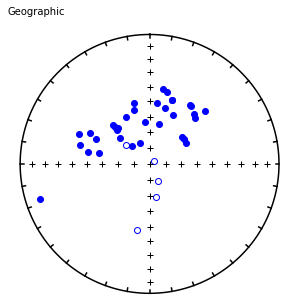

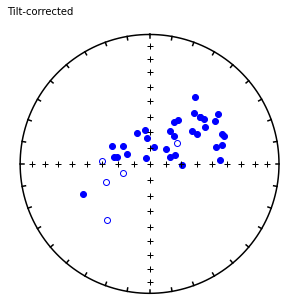

doing  200  iterations...please be patient.....

tightest grouping of vectors obtained at (95% confidence bounds):
49 - 133 percent unfolding
range of all bootstrap samples: 
35  -  139 percent unfolding


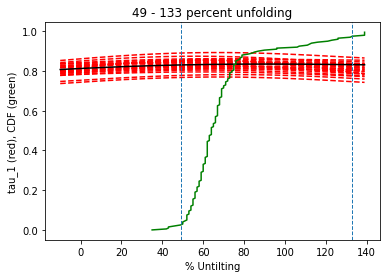

In [120]:
diddd_array = ipmag.make_diddd_array(all_pca_B_exp.specimen_dec.tolist(), all_pca_B_exp.specimen_inc.tolist(), all_pca_B_exp.Dip_ori.tolist(), all_pca_B_exp.Dip.tolist())
ipmag.bootstrap_fold_test(diddd_array, num_sims=200, min_untilt=-10, max_untilt=140)

#### Summary of results

In [191]:
res_exp = []
res_exp.append([Adir_is_exp, Adir_tc_exp, Avgp_is_exp, Avgp_tc_exp, Bdir_is_exp, Bdir_tc_exp, Bvgp_is_exp, Bvgp_tc_exp])
pd.DataFrame.from_dict(res_exp[0])

,dec,inc,n,r,k,alpha95,csd
0,3.444026,18.363931,81,73.989880,11.412073,4.873377,23.977437
1,13.859991,26.048331,81,74.262875,11.874501,4.768693,23.505925
2,279.260179,73.954848,81,75.749310,15.236094,4.168091,20.751438
3,239.407112,73.303311,81,75.856122,15.552469,4.122553,20.539286
4,353.442844,58.645553,37,24.442287,2.866764,17.173020,47.839767
5,42.506499,62.661989,37,24.700451,2.926937,16.904563,47.345463
6,89.054909,75.119572,37,22.555887,2.492365,19.190348,51.307306
7,153.996494,52.510915,37,22.667825,2.511831,19.067445,51.108110


### 3. Compared paleopoles derived from directions A and B with the South China APW path

#### Define functions for calculating GCD and plotting (rotated) paleopoles

In [121]:
def cal_gcd(pt1, pt2):
    import pygplates
    tmp1 = pygplates.PointOnSphere(float(pt1[0]), float(pt1[1]))
    tmp2 = pygplates.PointOnSphere(float(pt2[0]), float(pt2[1])) 
    return pygplates.GreatCircleArc(tmp1, tmp2).get_arc_length() * 180 / np.pi

def plot_scb_AB(Bvgp_tc, lc='r', lst='--', flippole=0, circle=0, Ref=[25.5, 111.1], rot_angle=0):
    if flippole == 1: 
        inc_tmp = - Bvgp_tc['inc']
        dec_tmp = (Bvgp_tc['dec'] - 180.) % 360.
    else:
        dec_tmp, inc_tmp = Bvgp_tc['dec'], Bvgp_tc['inc'] 
    if rot_angle != 0:
        finite_rotation = pygplates.FiniteRotation(Ref, math.radians(rot_angle))
        reconstructed_pole = finite_rotation * pygplates.PointOnSphere(float(inc_tmp), float(dec_tmp))
        inc_tmp, dec_tmp = reconstructed_pole.to_lat_lon()[0], reconstructed_pole.to_lat_lon()[1]

    X, Y = create_ellipse(dec_tmp, inc_tmp, Bvgp_tc['alpha95'], Bvgp_tc['alpha95'], 0, n=50)
    plt.plot(X, Y, color=lc, linestyle=lst, linewidth=1, alpha=1., transform=ccrs.Geodetic())
    if circle == 1:
        X, Y = create_ellipse(Ref[1], Ref[0], cal_gcd([inc_tmp,dec_tmp], Ref), cal_gcd([inc_tmp,dec_tmp], Ref), 0, n=50)
        plt.plot(X, Y, color='g', linestyle=lst, linewidth=1, alpha=1., transform=ccrs.Geodetic())

df = pd.read_excel('/Users/lei/Desktop/Projects/Manuscripts/Accomplished/SCB_Devonian/Project_details/Measurements_GY/GuanYang/20220108_check/data_info.xlsx',sheet_name='scbAPWP')
Ref = [25.5, 111.1] # geographic coordinates of Guanyang


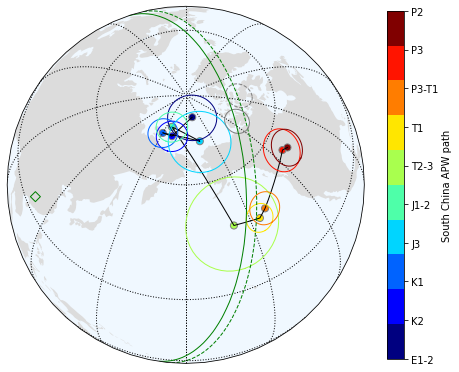

In [203]:
map_axis = ipmag.make_orthographic_map(central_longitude=180, central_latitude=60, land_color='gainsboro', land_edge_color='none', add_ocean=True,
ocean_color='aliceblue',figsize=(8,8), lat_grid=np.linspace(-60,60,4))
plt.scatter(Ref[1], Ref[0], s=50, marker='D', color='none', edgecolors='green', alpha=1., transform=ccrs.PlateCarree())
flagf = 'Y'
if flagf == 'Y':
    h1 = plt.scatter(df.Plonf.tolist(), df.Platf.tolist(), c=np.linspace(0, 1, len(df)), cmap=plt.cm.get_cmap('jet', len(df)),
                s=50, marker='o',edgecolors='grey', alpha=1., transform=ccrs.PlateCarree())
    h2 = plt.plot(df.Plonf.tolist(), df.Platf.tolist(), color='k', linestyle='-', linewidth=1, alpha=1., transform=ccrs.Geodetic())
else:
    h1 = plt.scatter(df.Plon.tolist(), df.Plat.tolist(), c=np.linspace(0, 1, len(df)), cmap=plt.cm.get_cmap('jet', len(df)),
                s=50, marker='o',edgecolors='grey', alpha=1., transform=ccrs.PlateCarree())
    h2 = plt.plot(df.Plon.tolist(), df.Plat.tolist(), color='k', linestyle='-', linewidth=1, alpha=1., transform=ccrs.Geodetic())
colors = plt.cm.jet(np.linspace(0, 1, len(df)))
for i, row in df.iterrows():
    if flagf == 'Y': X, Y = create_ellipse(row.Plonf, row.Platf, row.A95f, row.A95f, 0, n=50)
    else: X, Y = create_ellipse(row.Plon, row.Plat, row.A95, row.A95, 0, n=50)
    plt.plot(X, Y, color=colors[i], linestyle='-', linewidth=1, alpha=1., transform=ccrs.Geodetic())

rotang = -0
plot_scb_AB(Avgp_is, lc='grey', lst='--', flippole=0, circle=1, rot_angle=rotang)
plot_scb_AB(Avgp_tc, lc='grey', lst='-', flippole=0, circle=1, rot_angle=rotang)
# plot_scb_AB(Bvgp_is, lc='k', lst='--', flippole=0, circle=1, rot_angle=rotang)
# plot_scb_AB(Bvgp_tc, lc='k', lst='-', flippole=0, rot_angle=rotang)

cbar = plt.colorbar(shrink=.8, ticks=np.linspace(0, 1, len(df)), label='South China APW path')
cbar.ax.set_yticklabels(df.age.tolist());
# plt.savefig('/Users/lei/Desktop/Projects/Manuscripts/Accomplished/SCB_Devonian/WordVersions/GR_1221/apwp0.pdf')

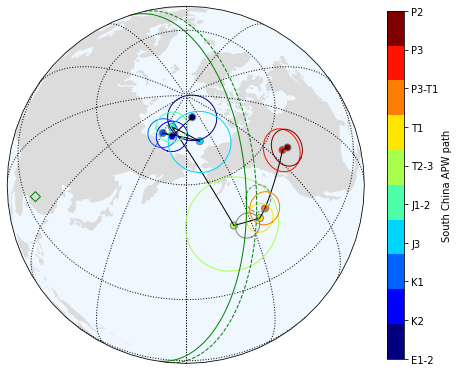

In [199]:
map_axis = ipmag.make_orthographic_map(central_longitude=180, central_latitude=60, land_color='gainsboro', land_edge_color='none', add_ocean=True,
ocean_color='aliceblue',figsize=(8,8), lat_grid=np.linspace(-60,60,4))
plt.scatter(Ref[1], Ref[0], s=50, marker='D', color='none', edgecolors='green', alpha=1., transform=ccrs.PlateCarree())

if flagf == 'Y':
    h1 = plt.scatter(df.Plonf.tolist(), df.Platf.tolist(), c=np.linspace(0, 1, len(df)), cmap=plt.cm.get_cmap('jet', len(df)),
                s=50, marker='o',edgecolors='grey', alpha=1., transform=ccrs.PlateCarree())
    h2 = plt.plot(df.Plonf.tolist(), df.Platf.tolist(), color='k', linestyle='-', linewidth=1, alpha=1., transform=ccrs.Geodetic())
else:
    h1 = plt.scatter(df.Plon.tolist(), df.Plat.tolist(), c=np.linspace(0, 1, len(df)), cmap=plt.cm.get_cmap('jet', len(df)),
                s=50, marker='o',edgecolors='grey', alpha=1., transform=ccrs.PlateCarree())
    h2 = plt.plot(df.Plon.tolist(), df.Plat.tolist(), color='k', linestyle='-', linewidth=1, alpha=1., transform=ccrs.Geodetic())
colors = plt.cm.jet(np.linspace(0, 1, len(df)))
for i, row in df.iterrows():
    if flagf == 'Y': X, Y = create_ellipse(row.Plonf, row.Platf, row.A95f, row.A95f, 0, n=50)
    else: X, Y = create_ellipse(row.Plon, row.Plat, row.A95, row.A95, 0, n=50)
    plt.plot(X, Y, color=colors[i], linestyle='-', linewidth=1, alpha=1., transform=ccrs.Geodetic())

rotang = -35
plot_scb_AB(Avgp_is, lc='grey', lst='--', flippole=0, circle=1, rot_angle=rotang)
plot_scb_AB(Avgp_tc, lc='grey', lst='-', flippole=0, circle=1, rot_angle=rotang)
# plot_scb_AB(Bvgp_is, lc='k', lst='--', flippole=0, circle=0, rot_angle=rotang)
# plot_scb_AB(Bvgp_tc, lc='k', lst='-', flippole=0, rot_angle=rotang)

cbar = plt.colorbar(shrink=.8, ticks=np.linspace(0, 1, len(df)), label='South China APW path')
cbar.ax.set_yticklabels(df.age.tolist());
# plt.savefig('/Users/lei/Desktop/Projects/Manuscripts/Accomplished/SCB_Devonian/WordVersions/GR_1221/apwp1.pdf')

In [204]:
def cal_plat(Ref, Avgp_is):
    # [age, plat, plat-A95, plat+A95]
    scbA_is = []
    for i in list(np.arange(0, 430, 20)):
        # plat = 90 - cal_gcd([Avgp_is['inc'], Avgp_is['dec']], Ref)
        dec, inc = pmag.vgp_di(Avgp_is['inc'], Avgp_is['dec'], Ref[0], Ref[1]) 
        plat = pmag.plat(inc)
        scbA_is.append([i, plat, plat-Avgp_is['alpha95'], plat+Avgp_is['alpha95']]) 
    return np.asarray(scbA_is)

def apwp_plat(Ref, flagf='Y'):
    plat_exps = list()
    # T12 apwps
    df = pd.read_excel('/Users/lei/Desktop/Projects/Manuscripts/Accomplished/SCB_Devonian/Project_details/Measurements_GY/GuanYang/20220108_check/data_info.xlsx',sheet_name='scbAPWP')
    # df = df.sort_values(by='Age', ascending=False)
    for i, row in df.iterrows():
        # dec, inc = pmag.vgp_di(row.Plat, row.Plong, row.Slat, row.Slong)
        if flagf == 'Y':
            dec, inc = pmag.vgp_di(row.Platf, row.Plonf, Ref[0], Ref[1])
            plat_exps.append([row.ageV, pmag.plat(inc), pmag.plat(inc)-row.A95f, pmag.plat(inc)+row.A95f])
        else:
            dec, inc = pmag.vgp_di(row.Plat, row.Plon, Ref[0], Ref[1])
            plat_exps.append([row.ageV, pmag.plat(inc), pmag.plat(inc)-row.A95, pmag.plat(inc)+row.A95])
    # [age, plat, plat-A95, plat+A95]
    plat_exps = np.asarray(plat_exps)
    return plat_exps

# Ref = [25.5, 111.1]
plat_exps_W17 = apwp_plat(Ref, flagf)
# plat_exps_W17
plat_A_is = cal_plat(Ref, Avgp_is)
plat_A_tc = cal_plat(Ref, Avgp_tc)
plat_B_is = cal_plat(Ref, Bvgp_is)
plat_B_tc = cal_plat(Ref, Bvgp_tc)
plat_A_is_exp = cal_plat(Ref, Avgp_is_exp)
plat_A_tc_exp = cal_plat(Ref, Avgp_tc_exp)
plat_B_is_exp = cal_plat(Ref, Bvgp_is_exp)
plat_B_tc_exp = cal_plat(Ref, Bvgp_tc_exp)

#### Calculate the post-420 Ma paleolatitudes of the Guanyang Succession

In [148]:
def ref_from_model(Ref, PlateID, model='TC16', anchor_id=0, time_list=np.arange(650, 490, -10)):
    plat_exps = list()
    for time in time_list:
        site = pygplates.PointOnSphere(float(Ref[0]), float(Ref[1]))
        # reconstruct sampling site to formation age
        if model == 'W22':
            model_filename = '/Users/lei/Desktop/Projects/Manuscripts/Curtin_Projects/before130/RotFiles/mod3LWig_Sib1cu.rot'
        if model == 'M21':
            model_filename = '/Users/lei/Desktop/Projects/Manuscripts/Coauthored_MS/2021_Avalon/Merdith_2021_ESR/1000_0_rotfile_Merdith_et_al.rot'
        if model == 'TC16':
            model_filename = '/Users/lei/Desktop/Projects/Manuscripts/Curtin_Projects/RecFiles/CEED6/Torsvik_Cocks_HybridRotationFile.rot'
        if model == 'S21':
            model_filename = '/Users/lei/Desktop/Projects/Manuscripts/Curtin_Projects/RecFiles/Scotese PaleoAtlas_v3/PALEOMAP Global Plate Model/PALEOMAP_PlateModel.rot'
        rotation_model = pygplates.RotationModel(model_filename)
        point_rotation = rotation_model.get_rotation(float(time), int(PlateID), anchor_plate_id=anchor_id)
        reconstructed_site = point_rotation * site
        plat_exps.append([time, reconstructed_site.to_lat_lon()[0], reconstructed_site.to_lat_lon()[1]])
    plat_exps = np.asarray(plat_exps)
    return plat_exps

plat_exps_TC16 = ref_from_model(Ref, PlateID=602, model='TC16', anchor_id=1, time_list=np.arange(430, 0, -10))
plat_exps_M21 = ref_from_model(Ref, PlateID=602, model='M21', anchor_id=1, time_list=np.arange(430, 0, -10))
plat_exps_W22 = ref_from_model(Ref, PlateID=602, model='W22', anchor_id=1, time_list=np.arange(430, 0, -10))
plat_exps_S21 = ref_from_model(Ref, PlateID=611, model='S21', anchor_id=1, time_list=np.arange(430, 0, -10))

Paleolatitude format:                 [Plat Plat- Plat+]
Paleolatitude from A in situ:         [ 8.57911749  4.12943912 13.02879586]
Paleolatitude from A tilt-corrected:  [12.10995644  7.91308571 16.30682717]
Paleolatitude from B in situ:         [29.96895527 16.45712012 43.48079043]
Paleolatitude from B tilt-corrected:  [40.42144095 26.64458112 54.19830077]


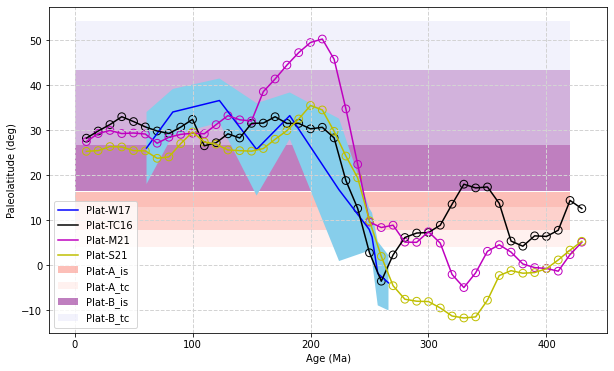

In [149]:
fig = plt.figure(figsize=(10, 6))
plt.fill_between(plat_A_tc[:,0], plat_A_tc[:,2], plat_A_tc[:,3], edgecolors='none', facecolors='salmon', alpha =.5, label='Plat-A_is')
plt.fill_between(plat_A_is[:,0], plat_A_is[:,2], plat_A_is[:,3], edgecolors='none', facecolors='mistyrose', alpha =.5, label='Plat-A_tc')
plt.fill_between(plat_B_is[:,0], plat_B_is[:,2], plat_B_is[:,3], edgecolors='none', facecolors='purple', alpha =.5, label='Plat-B_is')
plt.fill_between(plat_B_tc[:,0], plat_B_tc[:,2], plat_B_tc[:,3], edgecolors='none', facecolors='lavender', alpha =.5, label='Plat-B_tc')

plt.plot(plat_exps_W17[:,0], plat_exps_W17[:,1],'b-', label='Plat-W17')
plt.fill_between(plat_exps_W17[:,0], plat_exps_W17[:,2], plat_exps_W17[:,3], edgecolors='none', facecolors='skyblue')
plt.plot(plat_exps_TC16[:,0], plat_exps_TC16[:,1],'k-', label='Plat-TC16')
plt.scatter(plat_exps_TC16[:,0], plat_exps_TC16[:,1], color='None', s=60, marker='o',edgecolors='k')
plt.plot(plat_exps_M21[:,0], plat_exps_M21[:,1],'m-', label='Plat-M21')
plt.scatter(plat_exps_M21[:,0], plat_exps_M21[:,1], color='None', s=60, marker='o',edgecolors='m')
plt.plot(plat_exps_S21[:,0], plat_exps_S21[:,1],'y-', label='Plat-S21')
plt.scatter(plat_exps_S21[:,0], plat_exps_S21[:,1], color='None', s=60, marker='o',edgecolors='y')

# plt.plot(plat_exps_W22[:,0], plat_exps_W22[:,1],'g-', label='Plat-W22')
# plt.scatter(plat_exps_W22[:,0], plat_exps_W22[:,1], color='None', s=60, marker='o',edgecolors='g')
plt.grid(color='lightgrey', linestyle='--', linewidth=1) # plt.grid(True)
plt.legend(loc='lower left')
plt.ylabel('Paleolatitude (deg)')
plt.xlabel('Age (Ma)');
# plt.title('Plat of the sampling site');
print('Paleolatitude format:                 [Plat Plat- Plat+]')
print('Paleolatitude from A in situ:        ', plat_A_is[0][1:])
print('Paleolatitude from A tilt-corrected: ', plat_A_tc[0][1:])
print('Paleolatitude from B in situ:        ', plat_B_is[0][1:])
print('Paleolatitude from B tilt-corrected: ', plat_B_tc[0][1:])

Paleolatitude format:                 [Plat Plat- Plat+]
Paleolatitude from A in situ:         [ 9.76327108  5.59518056 13.93136159]
Paleolatitude from A tilt-corrected:  [14.57313586 10.45058308 18.69568864]
Distance between in-situ and tilt-corrected A poles:  11.041800672849844


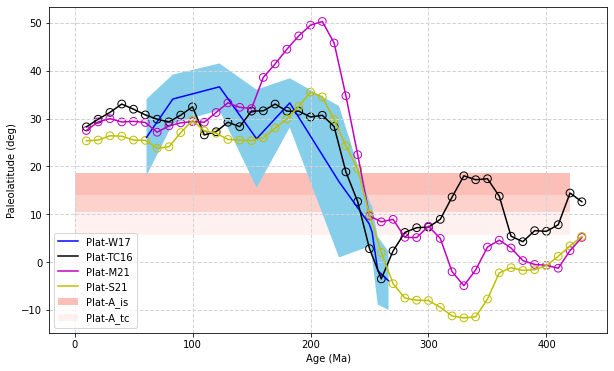

In [151]:
fig = plt.figure(figsize=(10, 6))
plt.fill_between(plat_A_tc_exp[:,0], plat_A_tc_exp[:,2], plat_A_tc_exp[:,3], edgecolors='none', facecolors='salmon', alpha =.5, label='Plat-A_is')
plt.fill_between(plat_A_is_exp[:,0], plat_A_is_exp[:,2], plat_A_is_exp[:,3], edgecolors='none', facecolors='mistyrose', alpha =.5, label='Plat-A_tc')
# plt.fill_between(plat_B_is_exp[:,0], plat_B_is_exp[:,2], plat_B_is_exp[:,3], edgecolors='none', facecolors='purple', alpha =.5, label='Plat-B_is')
# plt.fill_between(plat_B_tc_exp[:,0], plat_B_tc_exp[:,2], plat_B_tc_exp[:,3], edgecolors='none', facecolors='lavender', alpha =.5, label='Plat-B_tc')

plt.plot(plat_exps_W17[:,0], plat_exps_W17[:,1],'b-', label='Plat-W17')
plt.fill_between(plat_exps_W17[:,0], plat_exps_W17[:,2], plat_exps_W17[:,3], edgecolors='none', facecolors='skyblue')
plt.plot(plat_exps_TC16[:,0], plat_exps_TC16[:,1],'k-', label='Plat-TC16')
plt.scatter(plat_exps_TC16[:,0], plat_exps_TC16[:,1], color='None', s=60, marker='o',edgecolors='k')
plt.plot(plat_exps_M21[:,0], plat_exps_M21[:,1],'m-', label='Plat-M21')
plt.scatter(plat_exps_M21[:,0], plat_exps_M21[:,1], color='None', s=60, marker='o',edgecolors='m')
plt.plot(plat_exps_S21[:,0], plat_exps_S21[:,1],'y-', label='Plat-S21')
plt.scatter(plat_exps_S21[:,0], plat_exps_S21[:,1], color='None', s=60, marker='o',edgecolors='y')

# plt.plot(plat_exps_W22[:,0], plat_exps_W22[:,1],'g-', label='Plat-W22')
# plt.scatter(plat_exps_W22[:,0], plat_exps_W22[:,1], color='None', s=60, marker='o',edgecolors='g')
plt.grid(color='lightgrey', linestyle='--', linewidth=1) # plt.grid(True)
plt.legend(loc='lower left')
plt.ylabel('Paleolatitude (deg)')
plt.xlabel('Age (Ma)');
# plt.title('Plat of the sampling site');
print('Paleolatitude format:                 [Plat Plat- Plat+]')
print('Paleolatitude from A in situ:        ', plat_A_is_exp[0][1:])
print('Paleolatitude from A tilt-corrected: ', plat_A_tc_exp[0][1:])
print('Distance between in-situ and tilt-corrected A poles: ', cal_gcd([Avgp_is_exp['inc'], Avgp_is_exp['dec']], [Avgp_tc_exp['inc'], Avgp_tc_exp['dec']]))
# print('Paleolatitude from B in situ:        ', plat_B_is_exp[0][1:])
# print('Paleolatitude from B tilt-corrected: ', plat_B_tc_exp[0][1:])

# plt.savefig('/Users/lei/Desktop/Projects/Manuscripts/Accomplished/SCB_Devonian/WordVersions/GR_1221/plat.pdf')

### Interpretation of the paleolatitude diagram
The well-defined A directions are likely a Triassic or Late Jurassic overprint. Using the the in-situ and tilt-corrected A poles, we calculate paleolatitude of the sampling site Guanyang [25.5 $^oN$, 111.1 $^oE$] to be the pink (in-situ) and light pink (tilt-corrected) shadings, respectively. Those paleolatitudes are similar to the Triassic ones (the blue shading) according to the South China reference path (Wu et al., 2017). The fold test is indeterminate, possibly due to the little variation in bedding attitudes. Nonetheless, both in-situ and tilt-corrected paleolatitudes of the sampling site are similar to Triassic reference, with a minor difference of $\sim 5^o$. We interpret this similarity as an indication that component A was acquired during the early stage of the Indosinian folding (the main phase of folding in the area) in the Triassic. This scenario, if true, would also indicate that the study area was subject to localized rotation of $\sim 35^o$. There is a slight chance that component A was acquired during the Late Jurassic, given the minor overlapping paleolatitudes between the upper paleolatitude limit derived from the in-situ pole. This scenario would indicate a minor local rotation of $\sim 5^o$.  

Given that there is no primary depositional component, inclination flattening is not an issue for secondary directions. We compared the paleolatitude bands derived from component A poles with the South China APW path with the inclination correction (Wu et al., 2017). This is due to the fact that occurence of shallowing is supported by both laboratory compaction experiments and paleomagnetic observations (e.g., Kodoma, 2012), and that existing global paleogeographic model are based on APW paths with shallowing correction (Torsvik and Cocks, 2016; Merdith et al., 2021; Scotese, et al., 2021). 

The not well-constrained B directions are likely a Jurassic or Cretaceous or near-present day overprint. The in-situ (purple) and tilt-corrected (light purple) paleolatitudes of the sampling site since the Early Jurassic (200 Ma). Existing paleogeographic models suggest that South China might have reached approximately the present day paleolatitudes since 200 Ma (the blue shading).